In [2]:
!python -V

Python 3.9.12


In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [1]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("New York City Taxi Experiment 3")

/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
2025/06/07 16:29:50 INFO mlflow.tracking.fluent: Experiment with name 'New York City Taxi Experiment 3' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/4', creation_time=1749313790601, experiment_id='4', last_update_time=1749313790601, lifecycle_stage='active', name='New York City Taxi Experiment 3', tags={}>

In [36]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [37]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)

(54373, 51497)

In [25]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [26]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
with mlflow.start_run():
    mlflow.log_param("alpha", 0.01) # Example hyperparameter
    mlflow.set_tag("developer", "Mark") # Optional tag
    mlflow.log_param("train_data_path", "data/jan_2021.csv")
    mlflow.log_param("valid_data_path", "data/feb_2021.csv")

    # Train model here...
    model = LinearRegression()
    model.fit(X_train, y_train)
#     rmse = evaluate_rmse(model, X_valid, y_valid)
    rmse = mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse) # Save the model artifact if desired

    mlflow.sklearn.log_model(model, "model")

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

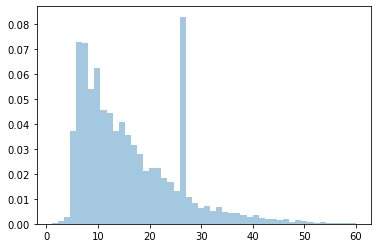

In [31]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [32]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [41]:
with mlflow.start_run():
    mlflow.log_param("alpha", 0.01) # Example hyperparameter
    mlflow.set_tag("developer", "Mark") # Optional tag
    mlflow.log_param("train_data_path", "data/jan_2021.csv")
    mlflow.log_param("valid_data_path", "data/feb_2021.csv")

    # Train model here...
    model = Lasso(alpha=0.01)
    model.fit(X_train, y_train)
#     rmse = evaluate_rmse(model, X_valid, y_valid)
    rmse = mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse) # Save the model artifact if desired

    mlflow.sklearn.log_model(model, "model")

2025/06/07 16:53:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpy2ye3deu/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/07 16:53:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
